In [1]:
# Colab Cell 1: Setup and Data Download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# --- Download the data directly to Colab ---
# Define the URL and local file path
data_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/matrix/GSE45827_series_matrix.txt.gz"
file_path = "GSE45827_series_matrix.txt.gz"
print(f"Downloading data from: {data_url}")
try:
    # Use pandas read_csv directly with the URL for gzipped files (it handles gzip and HTTP)
    import requests
    response = requests.get(data_url)
    response.raise_for_status() # Raise an exception for bad status codes
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f"'{file_path}' downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except Exception as e:
    print(f"An unexpected error occurred during download: {e}")

'GSE45827_series_matrix.txt.gz' downloaded successfully.


In [2]:
# Data Loading Function - METADATA PARSING

def load_geo_matrix(file_path):
    """
    Loads and parses a GEO series matrix .txt.gz file into a pandas DataFrame.
    Separates metadata from the expression data.
    """
    metadata = {}
    data_lines_raw = [] # Store all non-metadata lines initially

    with gzip.open(file_path, 'rt') as f: # 'rt' for read as text
        for line in f:
            stripped_line = line.strip()
            if stripped_line.startswith('!'):
                # This is a metadata line
                # Try to split by the first tab or space after '!'
                parts = stripped_line[1:].split('\t', 1) # Try tab first
                if len(parts) == 1: # If no tab, try space
                    parts = stripped_line[1:].split(' ', 1)
                if len(parts) == 2:
                    key = parts[0].strip()
                    value = parts[1].strip()
                    # Remove quotes from value if present
                    if value.startswith('"') and value.endswith('"'):
                        value = value[1:-1]
                    # Handle multi-line metadata values (e.g., !Sample_title, !Sample_characteristics_ch1)
                    if key in metadata:
                        # Append to list if key already exists, useful for !Sample_characteristics_ch1
                        if isinstance(metadata[key], list):
                            metadata[key].append(value)
                        else:
                            metadata[key] = [metadata[key], value] # Convert to list if first duplicate
                    else:
                        metadata[key] = value
                # else: print(f"Warning: Could not parse metadata line: {stripped_line}") # Debugging
            elif stripped_line: # If it's not a metadata line AND not empty
                data_lines_raw.append(stripped_line)
    # --- Find the true start of the data matrix ---
    data_start_index = -1
    for i, line in enumerate(data_lines_raw):
        if line.startswith('ID_REF\t'): # Specific header for this dataset
            data_start_index = i
            break
    if data_start_index == -1:
        if data_lines_raw:
             data_start_index = 0 # Assume the first non-metadata line is the header
             print("Warning: 'ID_REF\\t' not found. Assuming the first non-metadata line is the data header.")
        else:
            raise ValueError("Could not find any data lines after metadata. File might be malformed or empty.")
    # Read the data into a DataFrame
    data_str = "\n".join(data_lines_raw[data_start_index:])
    df = pd.read_csv(StringIO(data_str), sep='\t', index_col=0, header=0)
    return df, metadata
# --- Execute data loading ---
file_path = "GSE45827_series_matrix.txt.gz" # Ensure file_path is defined if running this cell independently
try:
    expression_data, geo_metadata = load_geo_matrix(file_path)
    print("\nSuccessfully loaded expression data and metadata!")
    print("\nExpression Data Head (first 5 rows, first 5 columns):")
    print(expression_data.iloc[:5, :5])
    print("\nShape of Expression Data (genes x samples):", expression_data.shape)
    print("\nMetadata Keys:")
    # This loop will now hopefully print the keys if they are successfully parsed
    if geo_metadata: # Check if dictionary is not empty
        for key in geo_metadata.keys():
            if isinstance(geo_metadata[key], list) and len(geo_metadata[key]) > 5:
                print(f"- {key}: {geo_metadata[key][:5]}... (first 5 elements)")
            else:
                print(f"- {key}: {geo_metadata[key]}")
    else:
        print("No metadata keys found. Parsing error or file structure unexpected.")

except Exception as e:
    print(f"Error during data loading: {e}")


Successfully loaded expression data and metadata!

Expression Data Head (first 5 rows, first 5 columns):
           GSM1116084  GSM1116085  GSM1116086  GSM1116087  GSM1116088
ID_REF                                                               
1007_s_at     9.47065     9.67440    10.20800    10.11420    11.16360
1053_at       8.36311     8.72194     7.78601     9.44537     7.71242
117_at        5.95426     7.02523     6.39671     4.56023     5.29008
1294_at       6.02119     7.24581     6.85310     5.42786     7.51120
1316_at       3.22997     3.29352     3.26204     3.34766     3.59086

Shape of Expression Data (genes x samples): (29873, 155)

Metadata Keys:
- Series_title: Expression data from Breast cancer subtypes
- Series_geo_accession: GSE45827
- Series_status: Public on Mar 24 2016
- Series_submission_date: Apr 05 2013
- Series_last_update_date: Mar 25 2019
- Series_pubmed_id: 27006338
- Series_summary: Expression data from Breast cancer subtypes
- Series_overall_design: In a 


--- Visualizing Initial Data Distributions ---


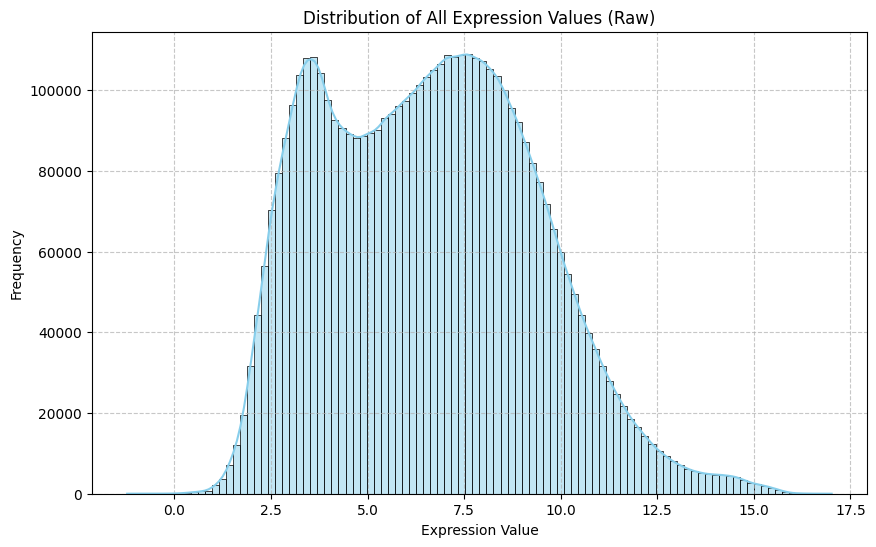

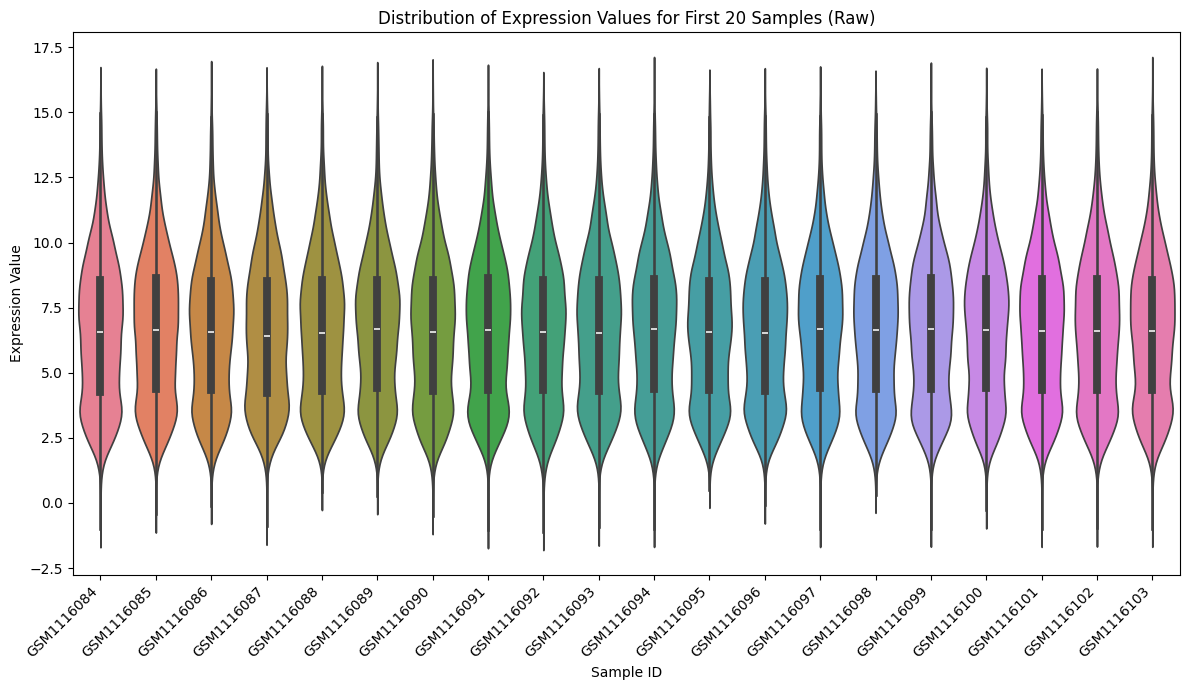

In [3]:
# Colab Cell 3: Initial Data Visualization

if 'expression_data' in locals() and expression_data is not None:
    # Ensure data is numeric for plotting
    expression_data_numeric = expression_data.apply(pd.to_numeric, errors='coerce')
    expression_data_numeric.fillna(expression_data_numeric.mean(), inplace=True)

    print("\n--- Visualizing Initial Data Distributions ---")

    # Plot 1: Distribution of All Expression Values
    plt.figure(figsize=(10, 6))
    sns.histplot(expression_data_numeric.values.flatten(), bins=100, kde=True, color='skyblue')
    plt.title('Distribution of All Expression Values (Raw)')
    plt.xlabel('Expression Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Plot 2: Distribution of Expression Values for First 20 Samples (Violin Plot)
    plt.figure(figsize=(12, 7))
    sns.violinplot(data=expression_data_numeric.iloc[:, :20]) # Plot first 20 samples to avoid clutter
    plt.title('Distribution of Expression Values for First 20 Samples (Raw)')
    plt.xlabel('Sample ID')
    plt.ylabel('Expression Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Expression data not loaded. Please run previous cells.")

In [4]:
# Colab Cell 4: Data Preprocessing - FINAL REVISION FOR METADATA ACCESS

if 'expression_data' in locals() and expression_data is not None and 'geo_metadata' in locals() and geo_metadata is not None:
    print("\n--- Starting Data Preprocessing ---")

    # 1. Transpose the data: ML models expect samples as rows, features (genes) as columns.
    X = expression_data.T
    print("Shape of X (samples x features) BEFORE numeric conversion and imputation:", X.shape)

    # 2. Convert to numeric and handle missing values
    X = X.apply(pd.to_numeric, errors='coerce') # Coerce non-numeric to NaN

    print("Total missing values before imputation:", X.isnull().sum().sum())

    # Impute missing values with the mean of each feature/gene (column)
    X.fillna(X.mean(), inplace=True)
    print("Total missing values after imputation:", X.isnull().sum().sum())

    print("Data types after processing (should primarily be float64):")
    print(X.dtypes.value_counts())

    # 3. Extracting the Target Variable (y)
    print("\n--- Extracting Target Variable (y) from Metadata ---")

    # Sample IDs from X.index are reliable and match the GSM IDs
    sample_ids = X.index.tolist()
    print(f"Using X.index for sample IDs. Total: {len(sample_ids)}. First 5: {sample_ids[:5]}")

    # --- Robustly get the full string for Sample_source_name_ch1 ---
    source_names_list = []
    source_name_full_string = ""
    if 'Sample_source_name_ch1' in geo_metadata:
        val = geo_metadata['Sample_source_name_ch1']
        if isinstance(val, list) and len(val) > 0:
            source_name_full_string = val[0].strip() # It's a list, take first element
            print(f"Found 'Sample_source_name_ch1' as a list. Using its first element.")
        elif isinstance(val, str):
            source_name_full_string = val.strip() # It's a direct string
            print(f"Found 'Sample_source_name_ch1' as a direct string.")

        if source_name_full_string:
            source_names_list = [s.strip().replace('"', '') for s in source_name_full_string.split('\t')]
            print(f"Parsed {len(source_names_list)} source names from 'Sample_source_name_ch1'. First 5: {source_names_list[:5]}")
        else:
            print("Warning: 'Sample_source_name_ch1' value is empty after retrieval. Cannot extract specific subtypes.")
            source_names_list = ['Unknown'] * len(sample_ids) # Fallback if value is empty
    else:
        print("Error: 'Sample_source_name_ch1' not found in metadata. Cannot extract specific subtypes.")
        source_names_list = ['Unknown'] * len(sample_ids) # Fallback if key not found


    # --- Robustly get the full string for Sample_characteristics_ch1 ---
    characteristics_list = []
    char_full_string = ""
    if 'Sample_characteristics_ch1' in geo_metadata:
        val = geo_metadata['Sample_characteristics_ch1']
        if isinstance(val, list) and len(val) > 0:
            char_full_string = val[0].strip()
            print(f"Found 'Sample_characteristics_ch1' as a list. Using its first element.")
        elif isinstance(val, str):
            char_full_string = val.strip()
            print(f"Found 'Sample_characteristics_ch1' as a direct string.")

        if char_full_string:
            characteristics_list = [c.strip().replace('"', '') for c in char_full_string.split('\t')]
            print(f"Parsed {len(characteristics_list)} characteristics from 'Sample_characteristics_ch1'. First 5: {characteristics_list[:5]}")
        else:
            print("Warning: 'Sample_characteristics_ch1' value is empty after retrieval. May miss some classifications.")
            characteristics_list = [''] * len(sample_ids) # Fallback if value is empty
    else:
        print("Warning: 'Sample_characteristics_ch1' not found in metadata. May miss some classifications.")
        characteristics_list = [''] * len(sample_ids) # Fallback if key not found


    # Initialize a dictionary to store sample_id -> subtype mapping
    sample_subtype_map = {}

    # Ensure all lists are of the same length
    min_len = min(len(sample_ids), len(source_names_list), len(characteristics_list))
    if min_len < len(sample_ids):
        print(f"Warning: Mismatch in number of sample annotations. Truncating to {min_len} samples.")
        sample_ids = sample_ids[:min_len]
        source_names_list = source_names_list[:min_len]
        characteristics_list = characteristics_list[:min_len]

    if len(sample_ids) > 0:
        for i in range(len(sample_ids)):
            sample_id = sample_ids[i]
            source_name = source_names_list[i].lower() # Convert to lower for case-insensitive matching
            characteristic = characteristics_list[i].lower() # Convert to lower

            subtype = None

            # Prioritize Sample_source_name_ch1 for specific tumor subtypes
            if 'basal tumor sample' in source_name:
                subtype = 'Triple Negative'
            elif 'her2 tumor sample' in source_name:
                subtype = 'HER2'
            elif 'luminal a tumor sample' in source_name:
                subtype = 'Luminal A'
            elif 'luminal b tumor sample' in source_name:
                subtype = 'Luminal B'
            elif 'normal' in source_name: # Covers "Human Normal"
                subtype = 'Normal'
            elif 'cellline' in source_name: # Covers "Human CellLine"
                subtype = 'Cell Line'

            # Fallback to Sample_characteristics_ch1 for general categories if not caught above
            if subtype is None:
                if 'diagnosis: none (normal)' in characteristic:
                    subtype = 'Normal'
                elif 'cell line:' in characteristic:
                    subtype = 'Cell Line'
                elif 'diagnosis: breast cancer' in characteristic:
                    # If it's breast cancer but no specific subtype found,
                    # this means it wasn't specified in source_name either.
                    # Given the dataset description, it implies it should have one of the 4 subtypes.
                    # We will mark it as 'Undetermined Tumor'
                    subtype = 'Undetermined Tumor'

            if subtype is None: # If still no subtype after all checks
                subtype = 'Uncategorized'
                # print(f"Warning: Sample {sample_id} (source: '{source_name}', char: '{characteristic}') assigned 'Uncategorized'.") # Uncomment for detailed warnings

            sample_subtype_map[sample_id] = subtype

        print(f"Successfully processed {len(sample_subtype_map)} sample subtypes.")

    else:
        print(f"Error: No samples to process for subtype extraction.")
        # Set y to empty to prevent further errors if this step fails critically
        y_aligned = pd.Series([])
        X_aligned = pd.DataFrame([])

    # Create the y Series, reindexing to align with X (important for matching samples)
    y = pd.Series(sample_subtype_map, name='subtype').reindex(X.index)

    # Drop samples from X and y that do not have a defined subtype (NaN in y)
    initial_samples = X.shape[0]
    X_aligned, y_aligned = X.align(y.dropna(), join='inner', axis=0)

    print(f"Removed {initial_samples - X_aligned.shape[0]} samples due to missing subtype labels (NaNs).")

    print("\nNumber of samples with a determined subtype:", y_aligned.shape[0])
    print("Subtype Distribution (y_aligned.value_counts()):")
    print(y_aligned.value_counts())

    # Only proceed if there are samples remaining
    if y_aligned.shape[0] > 0:
        # Convert string labels to numerical labels for machine learning
        le = LabelEncoder()
        y_encoded = pd.Series(le.fit_transform(y_aligned), index=y_aligned.index, name='target_variable')
        print("\nEncoded Target Variable (y_encoded) Head:")
        print(y_encoded.head())
        print("\nEncoded Subtype Mapping:")
        for i, label in enumerate(le.classes_):
            print(f"{label}: {i}")

        # 4. Standardization of X (Features)
        print("\n--- Standardizing Features (X) ---")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_aligned) # Use X_aligned here!
        X_scaled_df = pd.DataFrame(X_scaled, columns=X_aligned.columns, index=X_aligned.index)
        print("Scaled Data Head (first 5 samples, first 5 genes):")
        print(X_scaled_df.iloc[:5, :5])
        print("Shape of X after scaling:", X_scaled_df.shape)
    else:
        print("No samples remaining after filtering for subtypes. Cannot standardize or build model.")
        X_scaled_df = pd.DataFrame([]) # Ensure X_scaled_df is empty if no samples

else:
    print("Data or metadata not loaded. Please run previous cells.")


--- Starting Data Preprocessing ---
Shape of X (samples x features) BEFORE numeric conversion and imputation: (155, 29873)
Total missing values before imputation: 0
Total missing values after imputation: 0
Data types after processing (should primarily be float64):
float64    29873
Name: count, dtype: int64

--- Extracting Target Variable (y) from Metadata ---
Using X.index for sample IDs. Total: 155. First 5: ['GSM1116084', 'GSM1116085', 'GSM1116086', 'GSM1116087', 'GSM1116088']
Found 'Sample_source_name_ch1' as a direct string.
Parsed 155 source names from 'Sample_source_name_ch1'. First 5: ['Human Basal Tumor Sample', 'Human Basal Tumor Sample', 'Human Her2 Tumor Sample', 'Human Basal Tumor Sample', 'Human Her2 Tumor Sample']
Found 'Sample_characteristics_ch1' as a list. Using its first element.
Parsed 155 characteristics from 'Sample_characteristics_ch1'. First 5: ['diagnosis: Breast cancer', 'diagnosis: Breast cancer', 'diagnosis: Breast cancer', 'diagnosis: Breast cancer', 'diagn


--- Visualizing Data After Preprocessing (PCA) ---


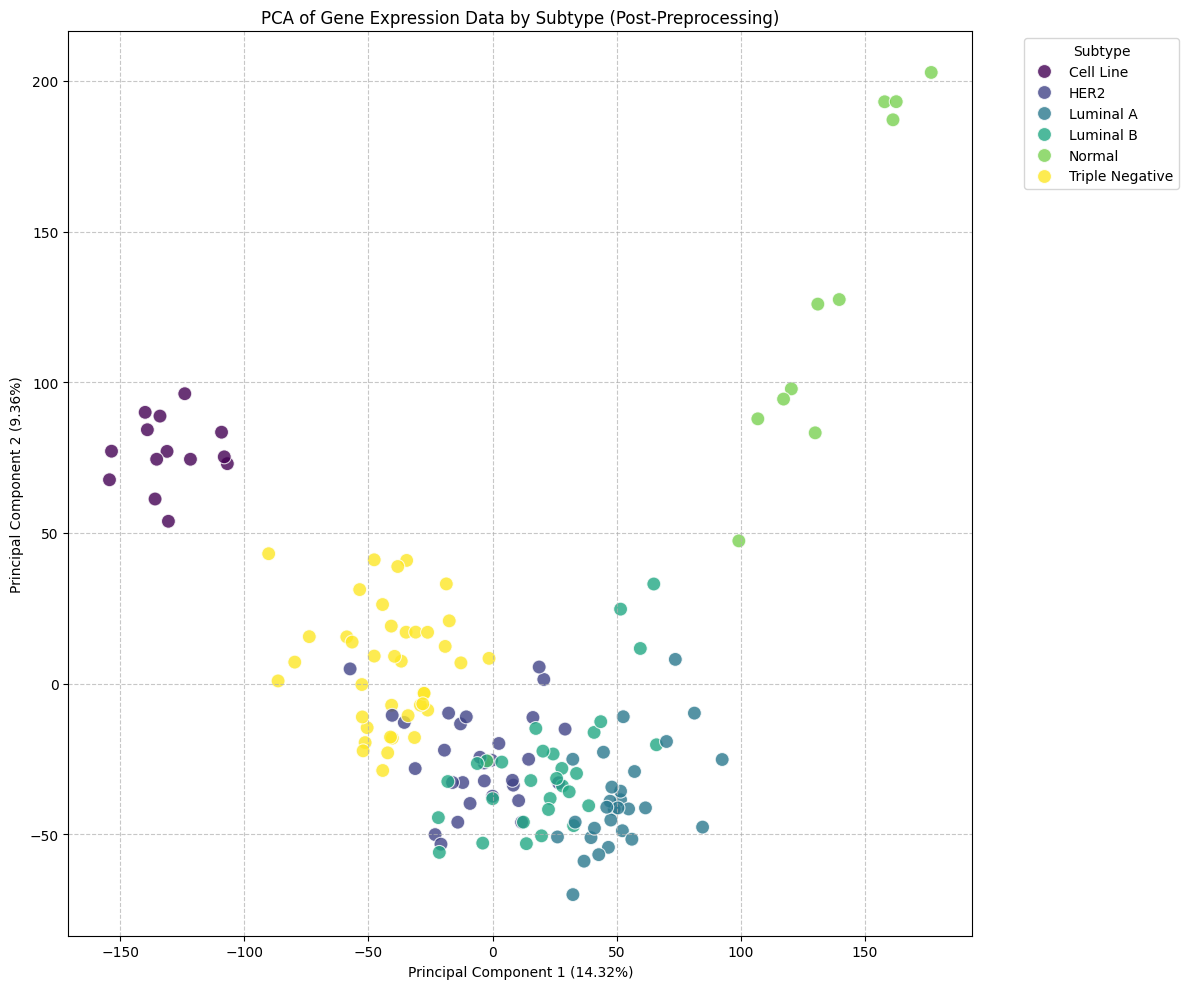

Explained variance by PC1: 0.1432
Explained variance by PC2: 0.0936
Total explained variance by first 2 PCs: 0.2368


In [5]:
#Visualization After Preprocessing (PCA)

if 'X_scaled_df' in locals() and 'y_encoded' in locals() and 'le' in locals():
    print("\n--- Visualizing Data After Preprocessing (PCA) ---")
    # Perform PCA on the scaled data
    pca = PCA(n_components=2) # Get the first two principal components
    principal_components = pca.fit_transform(X_scaled_df)
    pca_df = pd.DataFrame(data=principal_components,
                          columns=['Principal Component 1', 'Principal Component 2'],
                          index=X_scaled_df.index)

    # Combine PCA results with encoded labels for plotting
    combined_pca_y = pca_df.join(y_encoded, how='inner')
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2',
                    hue='target_variable',
                    palette='viridis', # Choose a color palette
                    data=combined_pca_y,
                    s=100, alpha=0.8,
                    legend='full')
    plt.title('PCA of Gene Expression Data by Subtype (Post-Preprocessing)')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create a custom legend with original subtype names
    handles, labels = plt.gca().get_legend_handles_labels()
    # Map encoded labels back to original names using le.inverse_transform
    # labels are strings of encoded numbers, e.g., '0', '1', '2'
    # we need to convert them to int, then inverse_transform

    # Fix for cases where hue creates string labels from int data
    new_labels = [le.inverse_transform([int(label)])[0] if label.isdigit() else label for label in labels]

    plt.legend(handles=handles, labels=new_labels, title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.4f}")
    print(f"Total explained variance by first 2 PCs: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.4f}")

else:
    print("Scaled features (X_scaled_df) or encoded labels (y_encoded) not available. Please run previous cells.")


--- Starting Model Building ---
Train set size: 124 samples
Test set size: 31 samples

Training RandomForestClassifier...
Training complete.

--- Model Evaluation ---
Classification Report:
                 precision    recall  f1-score   support

      Cell Line       1.00      1.00      1.00         3
           HER2       1.00      1.00      1.00         6
      Luminal A       1.00      1.00      1.00         6
      Luminal B       1.00      1.00      1.00         6
         Normal       1.00      1.00      1.00         2
Triple Negative       1.00      1.00      1.00         8

       accuracy                           1.00        31
      macro avg       1.00      1.00      1.00        31
   weighted avg       1.00      1.00      1.00        31

Accuracy: 1.0000

--- Top 15 Feature Importances ---


<ipython-input-6-3966730739>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


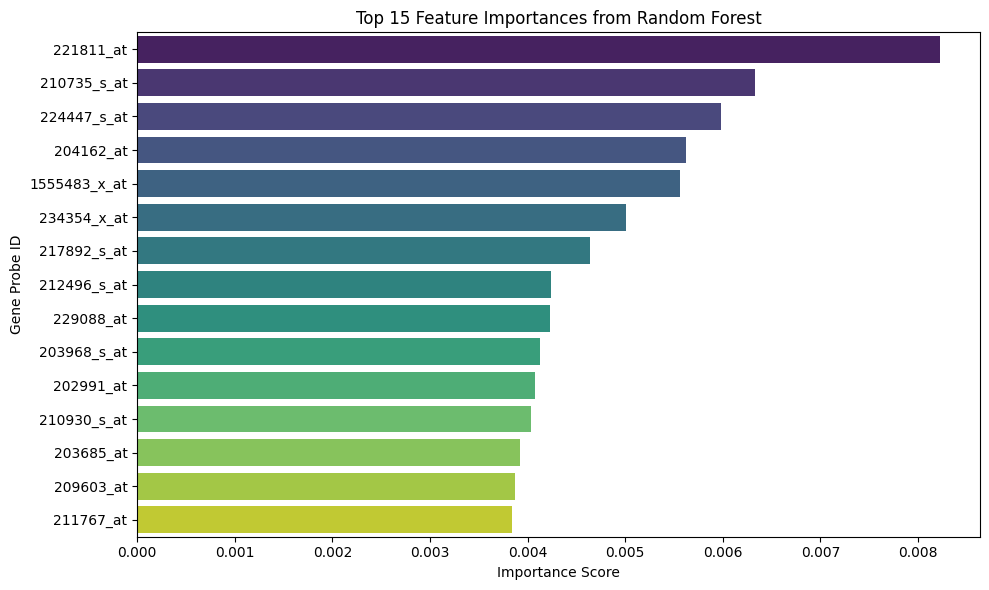

In [6]:
# Model Building and Evaluation

if 'X_scaled_df' in locals() and 'y_encoded' in locals():
    print("\n--- Starting Model Building ---")
    # Use the aligned and scaled data
    X_ml = X_scaled_df
    y_ml = y_encoded

    # Split the data into training and testing sets
    # stratify=y_ml ensures that the train and test sets have roughly the same proportion of target classes
    X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml)
    print(f"Train set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Initialize and train a RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
    print("\nTraining RandomForestClassifier...")
    model.fit(X_train, y_train)
    print("Training complete.")

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("\n--- Model Evaluation ---")
    print("Classification Report:")
    # Use le.classes_ for target_names to get a readable report with original subtype names
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Optional: Feature Importance Visualization
    print("\n--- Top 15 Feature Importances ---")
    feature_importances = pd.Series(model.feature_importances_, index=X_ml.columns)
    top_features = feature_importances.nlargest(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title('Top 15 Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Gene Probe ID')
    plt.tight_layout()
    plt.show()
else:
    print("Scaled features (X_scaled_df) or encoded labels (y_encoded) not available for model building.")

--- Starting Model Comparison ---
Train set size: 124 samples
Test set size: 31 samples

--- Training Random Forest ---
Training complete in 1.24 seconds.

--- Evaluating Random Forest ---
Classification Report:
                 precision    recall  f1-score   support

      Cell Line       1.00      1.00      1.00         3
           HER2       1.00      1.00      1.00         6
      Luminal A       1.00      1.00      1.00         6
      Luminal B       1.00      1.00      1.00         6
         Normal       1.00      1.00      1.00         2
Triple Negative       1.00      1.00      1.00         8

       accuracy                           1.00        31
      macro avg       1.00      1.00      1.00        31
   weighted avg       1.00      1.00      1.00        31

Accuracy: 1.0000

--- Training Logistic Regression ---
Training complete in 16.65 seconds.

--- Evaluating Logistic Regression ---
Classification Report:
                 precision    recall  f1-score   support

   

<ipython-input-7-1301654216>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


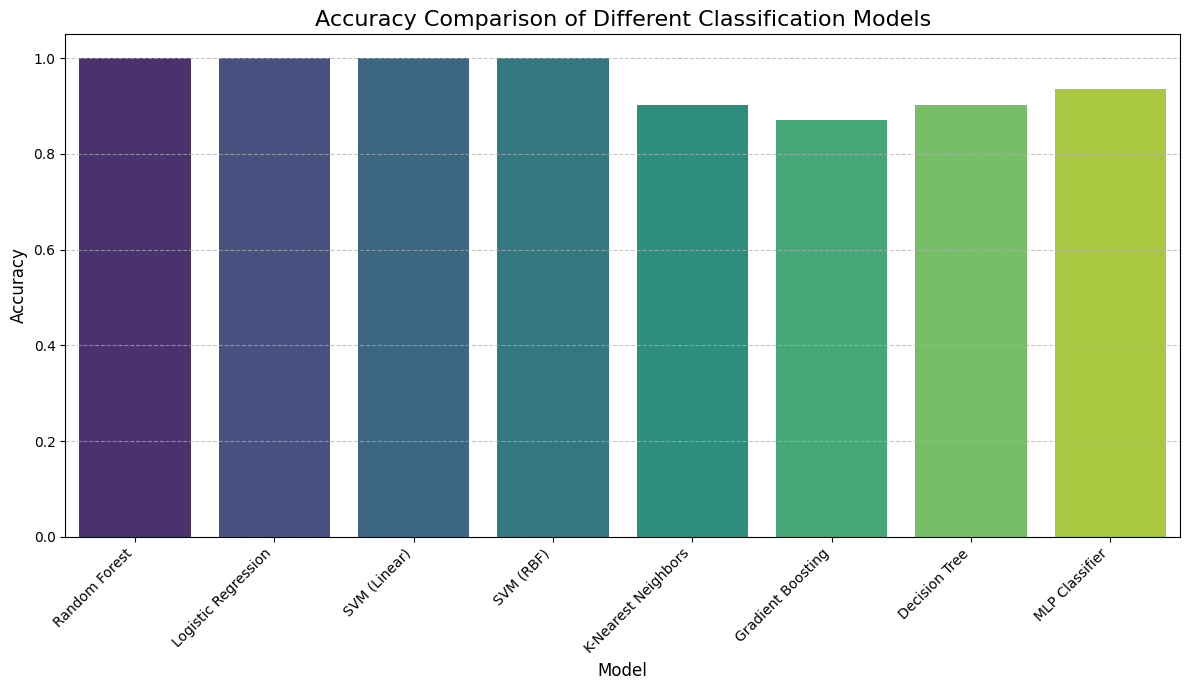


--- Model Comparison Complete ---


In [7]:
# Model Comparison and Visualization

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
# Import various classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

print("--- Starting Model Comparison ---")

# Ensure X_scaled_df, y_encoded, and le are available from previous cells.

# Re-create train/test split to ensure consistency if this cell is run independently
# (though ideally, X_train_scaled etc. from Cell 6 should already be available)
try:
    if 'X_scaled_df' not in locals() or 'y_encoded' not in locals():
        raise NameError("X_scaled_df or y_encoded not found. Please run previous data preprocessing cells.")

    # Use the same random state as in Cell 6 if it was specified for reproducibility
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"Train set size: {X_train_scaled.shape[0]} samples")
    print(f"Test set size: {X_test_scaled.shape[0]} samples")

except NameError as e:
    print(f"Error: {e}")
    print("Cannot proceed with model comparison. Please ensure previous cells (especially Cell 4 and Cell 6's data split part) have been executed.")
    exit() # This will stop the cell execution


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Trains a given model and evaluates its performance, returning metrics.
    Assumes 'le' (LabelEncoder) is globally available for inverse_transform.
    """
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training complete in {end_time - start_time:.2f} seconds.")
    print(f"\n--- Evaluating {model_name} ---")
    y_pred = model.predict(X_test)

    # Convert encoded predictions back to original labels for report readability
    # Check if le is defined, otherwise use encoded labels directly for report
    if 'le' in globals():
        y_test_labels = le.inverse_transform(y_test)
        y_pred_labels = le.inverse_transform(y_pred)
    else:
        print("Warning: LabelEncoder 'le' not found. Classification report will use encoded labels.")
        y_test_labels = y_test
        y_pred_labels = y_pred

    report = classification_report(y_test_labels, y_pred_labels, zero_division=0)
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print("Classification Report:")
    print(report)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy, report

# Dictionary to store accuracy for comparison
results = {}
# --- 1. Random Forest Classifier ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accuracy, _ = train_and_evaluate_model(rf_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "Random Forest")
results["Random Forest"] = rf_accuracy

# --- 2. Logistic Regression ---
# max_iter increased for convergence on this dataset size and complexity
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear') # 'liblinear' is good for smaller datasets
lr_accuracy, _ = train_and_evaluate_model(lr_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "Logistic Regression")
results["Logistic Regression"] = lr_accuracy

# --- 3. Support Vector Machine (Linear Kernel) ---
# Good for high-dimensional data
svm_linear_model = SVC(kernel='linear', random_state=42, probability=True) # probability=True for consistent API with others
svm_linear_accuracy, _ = train_and_evaluate_model(svm_linear_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "SVM (Linear)")
results["SVM (Linear)"] = svm_linear_accuracy

# --- 4. Support Vector Machine (RBF Kernel) ---
# Often effective for non-linear decision boundaries
svm_rbf_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf_accuracy, _ = train_and_evaluate_model(svm_rbf_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "SVM (RBF)")
results["SVM (RBF)"] = svm_rbf_accuracy

# --- 5. K-Nearest Neighbors ---
# n_neighbors is a hyperparameter; 5 is a common starting point
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy, _ = train_and_evaluate_model(knn_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "K-Nearest Neighbors")
results["K-Nearest Neighbors"] = knn_accuracy

# --- 6. Gradient Boosting Classifier ---
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_accuracy, _ = train_and_evaluate_model(gb_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "Gradient Boosting")
results["Gradient Boosting"] = gb_accuracy

# --- 7. Decision Tree Classifier ---
# A single decision tree can easily overfit; often used in ensembles
dt_model = DecisionTreeClassifier(random_state=42)
dt_accuracy, _ = train_and_evaluate_model(dt_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "Decision Tree")
results["Decision Tree"] = dt_accuracy

# --- 8. Multi-layer Perceptron (Neural Network) ---
# A simple feedforward neural network
# hidden_layer_sizes and max_iter are important hyperparameters
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose=False)
mlp_accuracy, _ = train_and_evaluate_model(mlp_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, "MLP Classifier")
results["MLP Classifier"] = mlp_accuracy


# --- Model Comparison Visualization ---
print("\n--- All Model Accuracies ---")
for model_name, accuracy in results.items():
    print(f"{model_name}: Accuracy = {accuracy:.4f}")

plt.figure(figsize=(12, 7))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title('Accuracy Comparison of Different Classification Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05) # Set y-axis limit slightly above 1.0 for better visual
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- Model Comparison Complete ---")

--- Visualizing a Single Decision Tree from the Random Forest ---


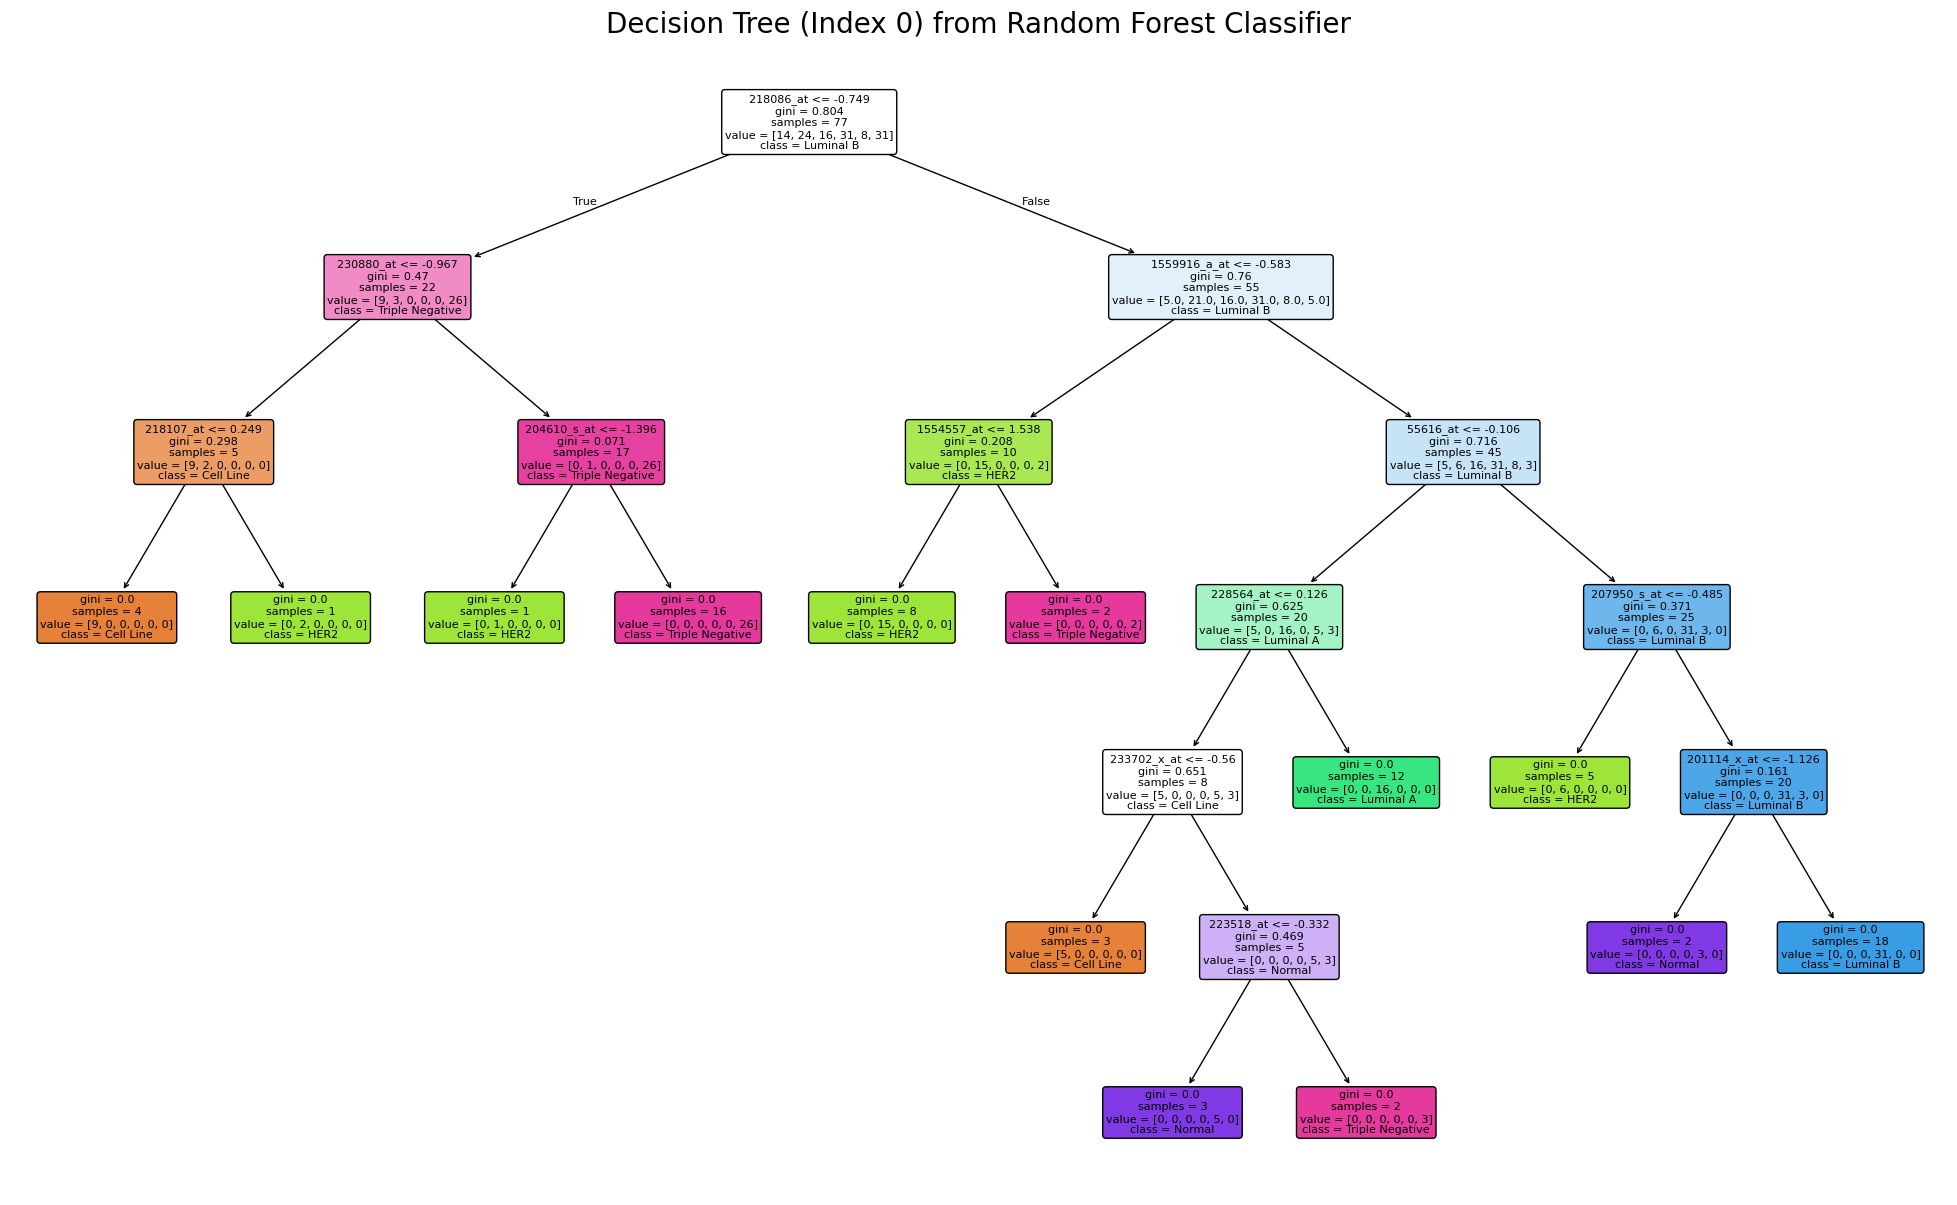


--- Tree Visualization Complete ---
Note: If the tree appears too dense, try setting 'max_depth' parameter in plot_tree (e.g., max_depth=3) for a simplified view.
Example: tree.plot_tree(single_tree, ..., max_depth=3)


In [8]:
# Visualize a Single Decision Tree from Random Forest

import matplotlib.pyplot as plt
from sklearn import tree

print("--- Visualizing a Single Decision Tree from the Random Forest ---")

# Ensure rf_model, X_scaled_df, and le are available from previous cells
# (rf_model was trained in Cell 6 or the comparison cell)
try:
    if 'rf_model' not in locals() or rf_model is None:
        raise NameError("RandomForestClassifier model (rf_model) not found. Please ensure Cell 6 or the model comparison cell was run successfully.")
    if 'X_scaled_df' not in locals() or X_scaled_df is None:
        raise NameError("X_scaled_df (scaled features) not found. Please ensure Cell 4 was run successfully.")
    if 'le' not in locals() or le is None:
        raise NameError("LabelEncoder (le) not found. Please ensure Cell 4 was run successfully.")

except NameError as e:
    print(f"Error: {e}")
    print("Cannot proceed with tree visualization. Make sure all previous necessary cells have been executed.")
    exit() # Stop execution if prerequisites are not met

# Select the first tree from the forest
single_tree = rf_model.estimators_[0]

# Get feature names (gene names) and class names (subtypes)
feature_names = X_scaled_df.columns.tolist()
class_names = le.classes_.tolist()

# Set up the plot for better readability
plt.figure(figsize=(25, 15)) # Adjust figure size as needed

# Plot the tree
# max_depth can be used to limit the depth for better readability, e.g., max_depth=3
tree.plot_tree(single_tree,
               feature_names=feature_names,
               class_names=class_names,
               filled=True,
               rounded=True,
               fontsize=8) # Adjust fontsize if labels overlap

plt.title("Decision Tree (Index 0) from Random Forest Classifier", fontsize=20)
plt.show()
print("\n--- Tree Visualization Complete ---")
print("Note: If the tree appears too dense, try setting 'max_depth' parameter in plot_tree (e.g., max_depth=3) for a simplified view.")
print("Example: tree.plot_tree(single_tree, ..., max_depth=3)")

--- Visualizing K-Nearest Neighbors Decision Boundaries (on PCA) ---
KNN model trained on 2D PCA data.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
<ipython-input-10-4184745955>:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


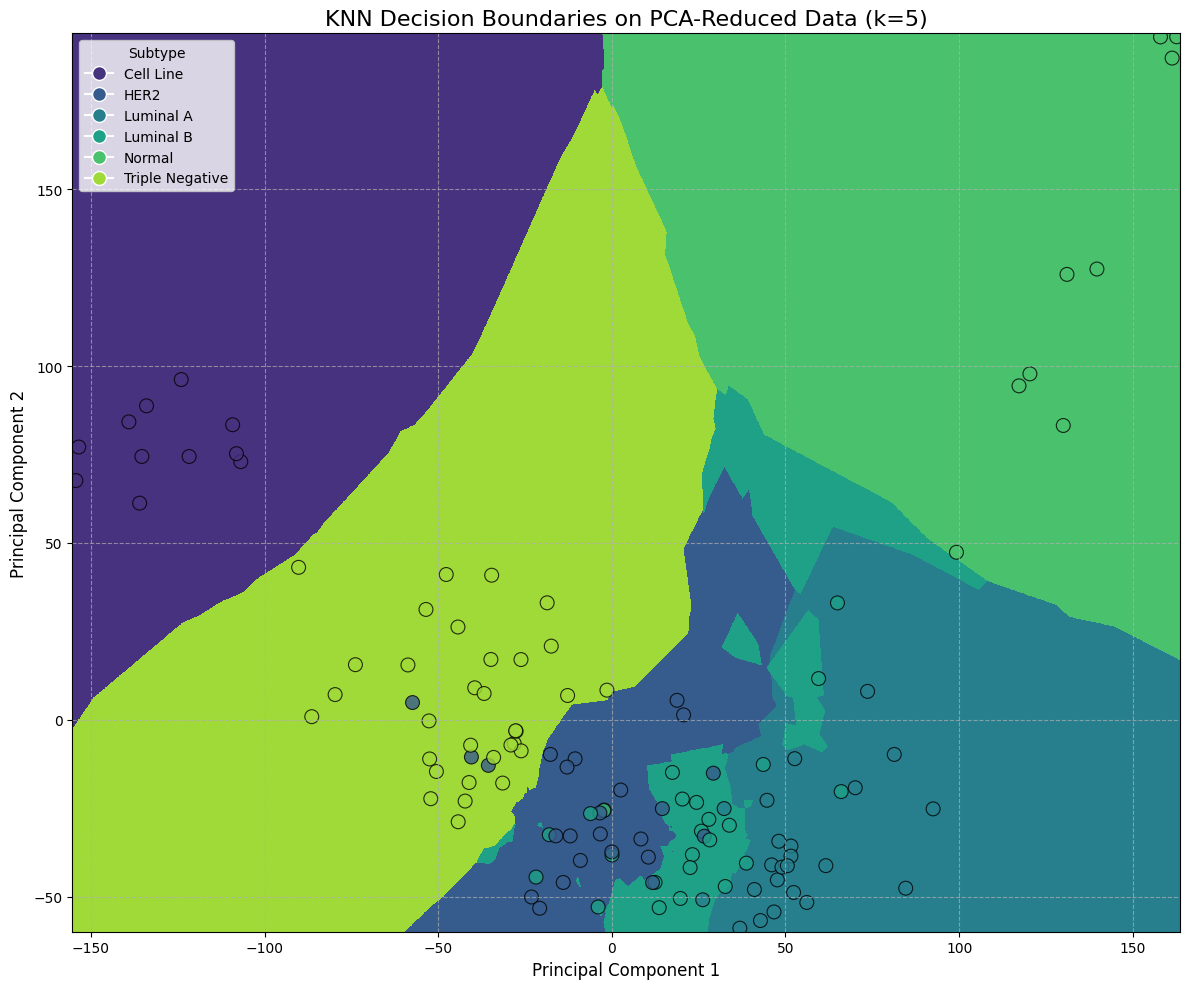


--- KNN Decision Boundary Visualization Complete ---
Note: This visualization is on the first two principal components, not the full dataset.


In [10]:
# Colab Cell: Visualize KNN Decision Boundaries (using PCA)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split

print("--- Visualizing K-Nearest Neighbors Decision Boundaries (on PCA) ---")

# Ensure X_scaled_df, y_encoded, and le are available
try:
    if 'X_scaled_df' not in locals() or X_scaled_df is None:
        raise NameError("X_scaled_df (scaled features) not found. Please ensure Cell 4 was run successfully.")
    if 'y_encoded' not in locals() or y_encoded is None:
        raise NameError("y_encoded (encoded labels) not found. Please ensure Cell 4 was run successfully.")
    if 'le' not in locals() or le is None:
         raise NameError("LabelEncoder (le) not found. Please ensure Cell 4 was run successfully.")

except NameError as e:
    print(f"Error: {e}")
    print("Cannot proceed with visualization. Make sure all previous necessary cells have been executed.")
    exit() # Stop execution if prerequisites are not met

# --- Use the first two principal components ---
# Re-apply PCA if it was not retained from a previous cell or to ensure consistency
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_df)

# Create a DataFrame for the 2D PCA data
pca_2d_df = pd.DataFrame(data=principal_components,
                          columns=['Principal Component 1', 'Principal Component 2'],
                          index=X_scaled_df.index)

# Ensure PCA data and encoded labels are aligned
aligned_pca_2d = pca_2d_df.loc[y_encoded.index] # Use the index from y_encoded for alignment
aligned_y_encoded = y_encoded

# Use the aligned data for splitting
X_pca_train, X_pca_test, y_train_encoded_aligned, y_test_encoded_aligned = train_test_split(
    aligned_pca_2d, aligned_y_encoded, test_size=0.2, random_state=42, stratify=aligned_y_encoded
)


# --- Train a KNN model on the 2D PCA data ---
# Use the same n_neighbors as in your comparison cell (n_neighbors=5)
knn_model_2d = KNeighborsClassifier(n_neighbors=5)
knn_model_2d.fit(X_pca_train, y_train_encoded_aligned)
print("KNN model trained on 2D PCA data.")


# --- Plotting the Decision Boundary ---

# Define mesh grid for plotting the decision boundary
x_min, x_max = X_pca_train['Principal Component 1'].min() - 1, X_pca_train['Principal Component 1'].max() + 1
y_min, y_max = X_pca_train['Principal Component 2'].min() - 1, X_pca_train['Principal Component 2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), # Use a smaller step for smoother boundary
                     np.arange(y_min, y_max, 0.1))

# Predict class for each point in the mesh grid
Z = knn_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create color maps for plotting
cmap_light = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex()) # Using viridis palette
cmap_bold = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex())


plt.figure(figsize=(12, 10))

# Plot the decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto') # Use shading='auto'

# Plot also the training points
sns.scatterplot(x=X_pca_train['Principal Component 1'], y=X_pca_train['Principal Component 2'],
                hue=y_train_encoded_aligned, palette=cmap_bold, edgecolor='k', s=100, alpha=0.8, legend=None) # Plot training points
plt.title('KNN Decision Boundaries on PCA-Reduced Data (k=5)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend with original class names
# Create a mapping from encoded label to original name
label_to_name = {i: name for i, name in enumerate(le.classes_)}
legend_handles = []
for encoded_label in sorted(y_train_encoded_aligned.unique()):
    original_name = label_to_name[encoded_label]
    # Create a proxy artist for the legend
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=original_name,
                                      markerfacecolor=cmap_bold(encoded_label), markersize=10))

plt.legend(handles=legend_handles, title="Subtype")

plt.tight_layout()
plt.show()

print("\n--- KNN Decision Boundary Visualization Complete ---")
print("Note: This visualization is on the first two principal components, not the full dataset.")

--- Visualizing Logistic Regression Decision Boundaries (on PCA) ---
Logistic Regression model trained on 2D PCA data.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
<ipython-input-11-2695751699>:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


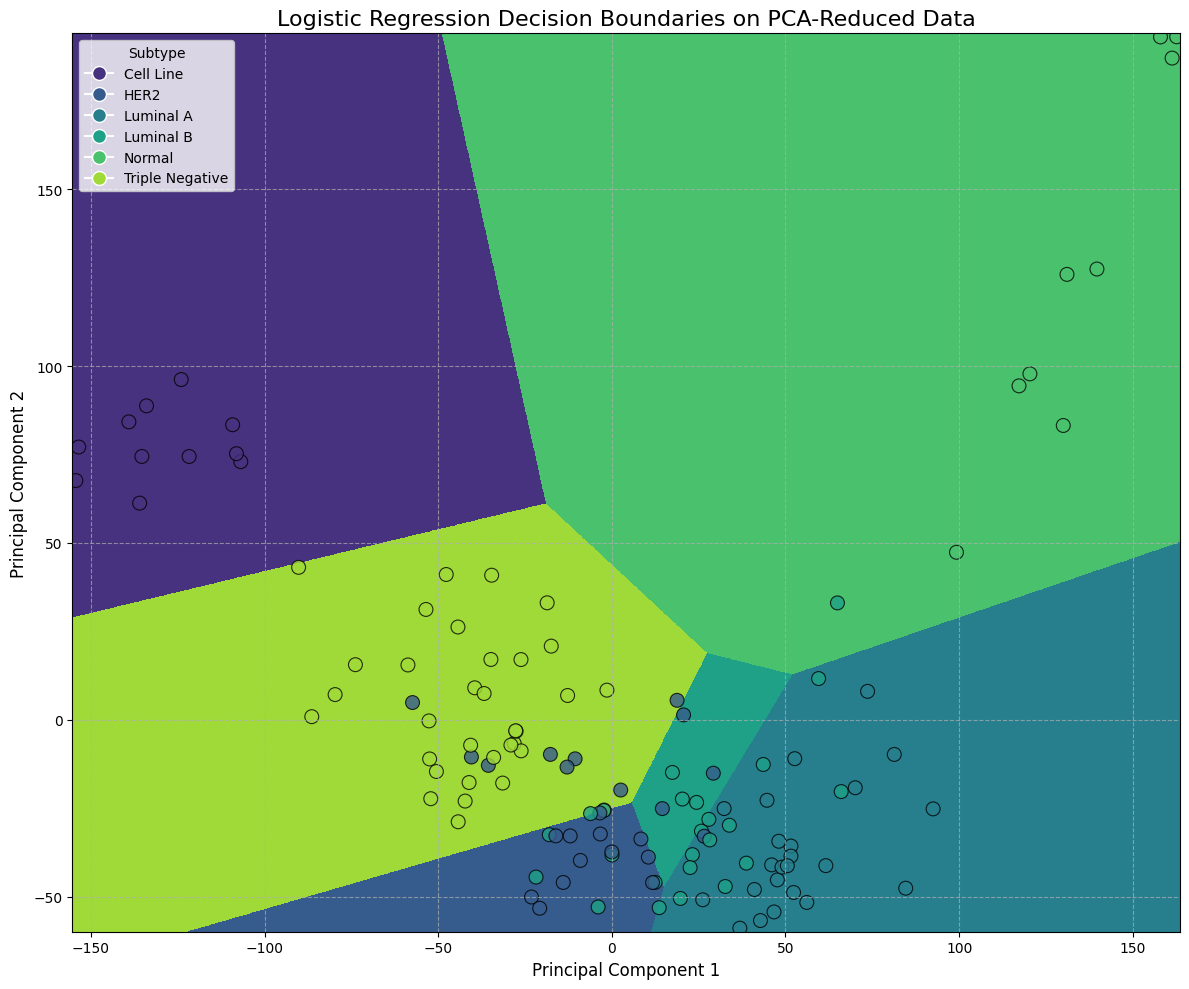


--- Logistic Regression Decision Boundary Visualization Complete ---
Note: This visualization is on the first two principal components, not the full dataset.


In [11]:
# Colab Cell: Visualize Logistic Regression Decision Boundaries (using PCA)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print("--- Visualizing Logistic Regression Decision Boundaries (on PCA) ---")

# Ensure X_scaled_df, y_encoded, and le are available
try:
    if 'X_scaled_df' not in locals() or X_scaled_df is None:
        raise NameError("X_scaled_df (scaled features) not found. Please ensure Cell 4 was run successfully.")
    if 'y_encoded' not in locals() or y_encoded is None:
        raise NameError("y_encoded (encoded labels) not found. Please ensure Cell 4 was run successfully.")
    if 'le' not in locals() or le is None:
         raise NameError("LabelEncoder (le) not found. Please ensure Cell 4 was run successfully.")
except NameError as e:
    print(f"Error: {e}")
    print("Cannot proceed with visualization. Make sure all previous necessary cells have been executed.")
    exit() # Stop execution if prerequisites are not met

# --- Use the first two principal components ---
# Re-apply PCA if it was not retained from a previous cell or to ensure consistency
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_df)

# Create a DataFrame for the 2D PCA data
pca_2d_df = pd.DataFrame(data=principal_components,
                          columns=['Principal Component 1', 'Principal Component 2'],
                          index=X_scaled_df.index)

# Ensure PCA data and encoded labels are aligned
aligned_pca_2d = pca_2d_df.loc[y_encoded.index] # Use the index from y_encoded for alignment
aligned_y_encoded = y_encoded

# Use the aligned data for splitting
X_pca_train, X_pca_test, y_train_encoded_aligned, y_test_encoded_aligned = train_test_split(
    aligned_pca_2d, aligned_y_encoded, test_size=0.2, random_state=42, stratify=aligned_y_encoded
)

# --- Train a Logistic Regression model on the 2D PCA data ---
# Use max_iter=1000 for convergence on this dataset size
lr_model_2d = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_model_2d.fit(X_pca_train, y_train_encoded_aligned)
print("Logistic Regression model trained on 2D PCA data.")

# --- Plotting the Decision Boundary ---

# Define mesh grid for plotting the decision boundary
x_min, x_max = X_pca_train['Principal Component 1'].min() - 1, X_pca_train['Principal Component 1'].max() + 1
y_min, y_max = X_pca_train['Principal Component 2'].min() - 1, X_pca_train['Principal Component 2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict class for each point in the mesh grid
Z = lr_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create color maps for plotting
cmap_light = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex())
cmap_bold = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex())

plt.figure(figsize=(12, 10))

# Plot the decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Plot also the training points
sns.scatterplot(x=X_pca_train['Principal Component 1'], y=X_pca_train['Principal Component 2'],
                hue=y_train_encoded_aligned, palette=cmap_bold, edgecolor='k', s=100, alpha=0.8, legend=None)
plt.title('Logistic Regression Decision Boundaries on PCA-Reduced Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend with original class names
label_to_name = {i: name for i, name in enumerate(le.classes_)}
legend_handles = []
for encoded_label in sorted(y_train_encoded_aligned.unique()):
    original_name = label_to_name[encoded_label]
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=original_name,
                                      markerfacecolor=cmap_bold(encoded_label), markersize=10))

plt.legend(handles=legend_handles, title="Subtype")

plt.tight_layout()
plt.show()

print("\n--- Logistic Regression Decision Boundary Visualization Complete ---")
print("Note: This visualization is on the first two principal components, not the full dataset.")

--- Visualizing SVM Decision Boundaries (Linear and RBF on PCA) ---
SVM (Linear) model trained on 2D PCA data.
SVM (RBF) model trained on 2D PCA data.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
<ipython-input-12-1253474091>:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


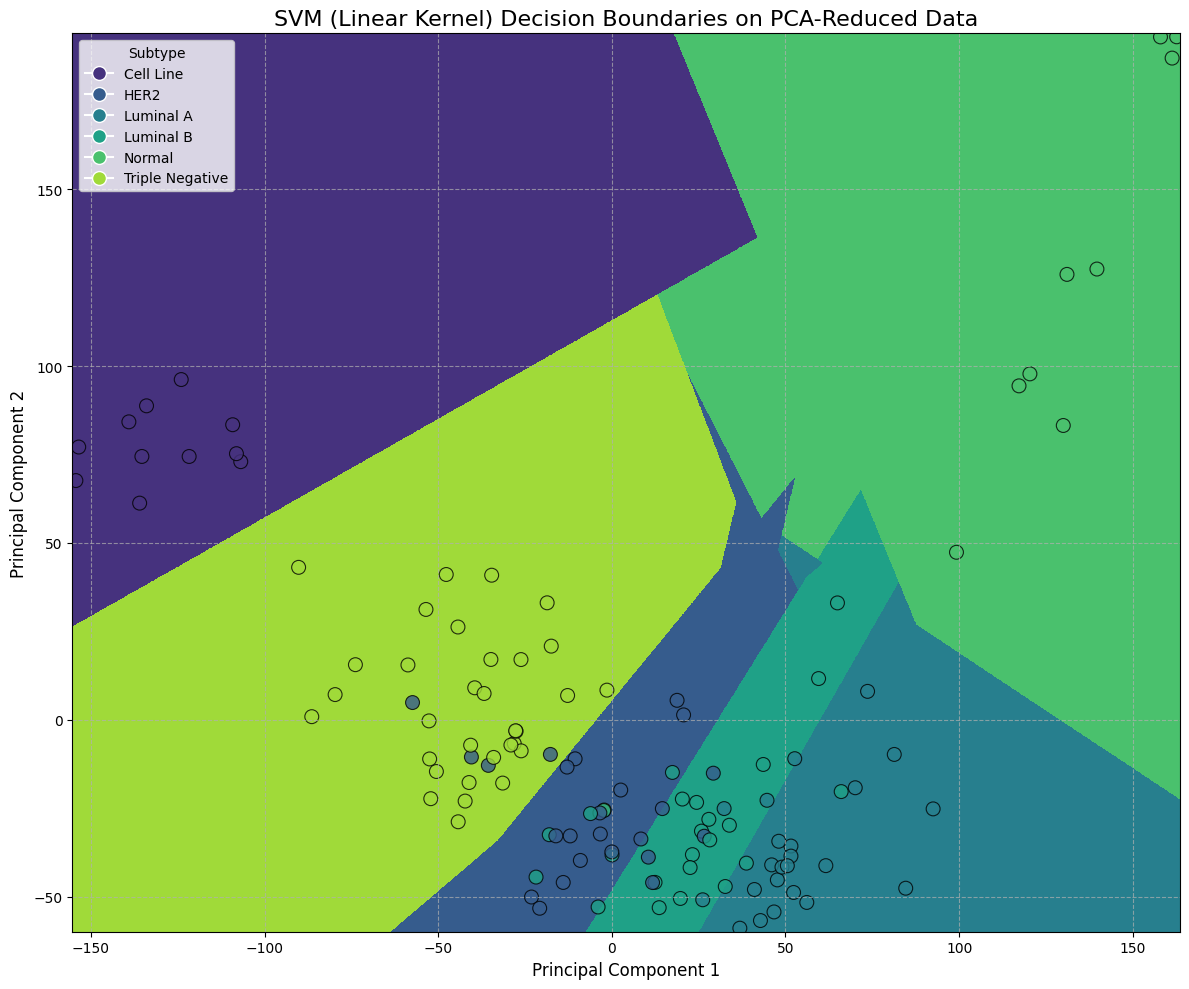

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
<ipython-input-12-1253474091>:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


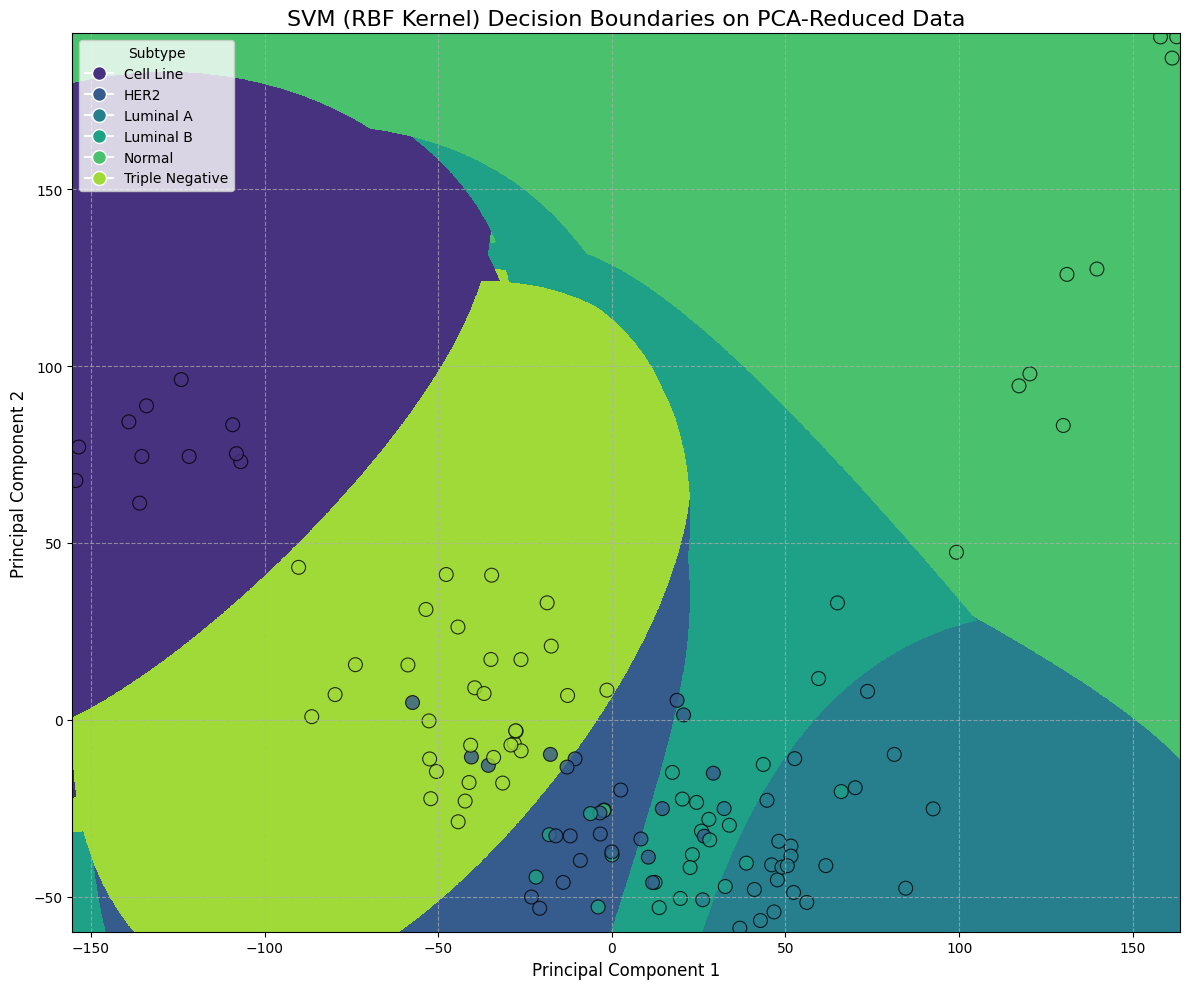


--- SVM Decision Boundary Visualization Complete ---
Note: This visualization is on the first two principal components, not the full dataset.


In [12]:
# Colab Cell: Visualize SVM Decision Boundaries (Linear and RBF on PCA)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print("--- Visualizing SVM Decision Boundaries (Linear and RBF on PCA) ---")
# Ensure X_scaled_df, y_encoded, and le are available
try:
    if 'X_scaled_df' not in locals() or X_scaled_df is None:
        raise NameError("X_scaled_df (scaled features) not found. Please ensure Cell 4 was run successfully.")
    if 'y_encoded' not in locals() or y_encoded is None:
        raise NameError("y_encoded (encoded labels) not found. Please ensure Cell 4 was run successfully.")
    if 'le' not in locals() or le is None:
         raise NameError("LabelEncoder (le) not found. Please ensure Cell 4 was run successfully.")
except NameError as e:
    print(f"Error: {e}")
    print("Cannot proceed with visualization. Make sure all previous necessary cells have been executed.")
    exit() # Stop execution if prerequisites are not met
# --- Use the first two principal components ---
# Re-apply PCA if it was not retained from a previous cell or to ensure consistency
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_df)
# Create a DataFrame for the 2D PCA data
pca_2d_df = pd.DataFrame(data=principal_components,
                          columns=['Principal Component 1', 'Principal Component 2'],
                          index=X_scaled_df.index)

# Ensure PCA data and encoded labels are aligned
aligned_pca_2d = pca_2d_df.loc[y_encoded.index] # Use the index from y_encoded for alignment
aligned_y_encoded = y_encoded
# Use the aligned data for splitting
X_pca_train, X_pca_test, y_train_encoded_aligned, y_test_encoded_aligned = train_test_split(
    aligned_pca_2d, aligned_y_encoded, test_size=0.2, random_state=42, stratify=aligned_y_encoded
)

# --- Train SVM models on the 2D PCA data ---
svm_linear_model_2d = SVC(kernel='linear', random_state=42, probability=True)
svm_linear_model_2d.fit(X_pca_train, y_train_encoded_aligned)
print("SVM (Linear) model trained on 2D PCA data.")
svm_rbf_model_2d = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf_model_2d.fit(X_pca_train, y_train_encoded_aligned)
print("SVM (RBF) model trained on 2D PCA data.")

# --- Plotting the Decision Boundaries ---

# Define mesh grid for plotting the decision boundary
x_min, x_max = X_pca_train['Principal Component 1'].min() - 1, X_pca_train['Principal Component 1'].max() + 1
y_min, y_max = X_pca_train['Principal Component 2'].min() - 1, X_pca_train['Principal Component 2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
# Create color maps for plotting
cmap_light = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex())
cmap_bold = ListedColormap(sns.color_palette("viridis", n_colors=len(le.classes_)).as_hex())
# --- Plot for SVM (Linear) ---
plt.figure(figsize=(12, 10))
Z_linear = svm_linear_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z_linear, cmap=cmap_light, shading='auto')
sns.scatterplot(x=X_pca_train['Principal Component 1'], y=X_pca_train['Principal Component 2'],
                hue=y_train_encoded_aligned, palette=cmap_bold, edgecolor='k', s=100, alpha=0.8, legend=None)
plt.title('SVM (Linear Kernel) Decision Boundaries on PCA-Reduced Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True, linestyle='--', alpha=0.7)
label_to_name = {i: name for i, name in enumerate(le.classes_)}
legend_handles = []
for encoded_label in sorted(y_train_encoded_aligned.unique()):
    original_name = label_to_name[encoded_label]
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=original_name,
                                      markerfacecolor=cmap_bold(encoded_label), markersize=10))
plt.legend(handles=legend_handles, title="Subtype")
plt.tight_layout()
plt.show()
# --- Plot for SVM (RBF) ---
plt.figure(figsize=(12, 10))
Z_rbf = svm_rbf_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z_rbf, cmap=cmap_light, shading='auto')
sns.scatterplot(x=X_pca_train['Principal Component 1'], y=X_pca_train['Principal Component 2'],
                hue=y_train_encoded_aligned, palette=cmap_bold, edgecolor='k', s=100, alpha=0.8, legend=None)
plt.title('SVM (RBF Kernel) Decision Boundaries on PCA-Reduced Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True, linestyle='--', alpha=0.7)
legend_handles = []
for encoded_label in sorted(y_train_encoded_aligned.unique()):
    original_name = label_to_name[encoded_label]
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=original_name,
                                      markerfacecolor=cmap_bold(encoded_label), markersize=10))
plt.legend(handles=legend_handles, title="Subtype")
plt.tight_layout()
plt.show()
print("\n--- SVM Decision Boundary Visualization Complete ---")
print("Note: This visualization is on the first two principal components, not the full dataset.")